In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as xn
import matplotlib.pyplot as plt

import csv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import joblib



# Ingestion des données

In [4]:

data = pd.read_csv("bank.csv ", sep=";")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [ ]:
data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
data.drop(["balance","duration"],axis = 1, inplace=True)


In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,no,no,cellular,19,oct,1,-1,0,unknown,no
1,33,services,married,secondary,no,yes,yes,cellular,11,may,1,339,4,failure,no
2,35,management,single,tertiary,no,yes,no,cellular,16,apr,1,330,1,failure,no
3,30,management,married,tertiary,no,yes,yes,unknown,3,jun,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,yes,no,unknown,5,may,1,-1,0,unknown,no


In [ ]:
data["y"].value_counts(normalize=True)

no     0.88476
yes    0.11524
Name: y, dtype: float64

In [ ]:
data["y"] = data["y"].apply(lambda val: 0 if val == "no" else 1)


In [ ]:
data["y"].value_counts(normalize=True)

0    0.88476
1    0.11524
Name: y, dtype: float64

In [ ]:
seed = 123
train, test = train_test_split(data, test_size=0.3,random_state= seed, stratify = data["y"])
test, validate = train_test_split(test, test_size=0.5, random_state = seed, stratify = test["y"])

print("Train data : ", train.shape)
print("Test data : ", test.shape)
print("Validate data : ", validate.shape)

Train data :  (3164, 15)
Test data :  (678, 15)
Validate data :  (679, 15)


In [ ]:
train["y"].value_counts(normalize=True)

0    0.88464
1    0.11536
Name: y, dtype: float64

In [ ]:
test["y"].value_counts(normalize=True)

0    0.884956
1    0.115044
Name: y, dtype: float64

In [ ]:
validate["y"].value_counts(normalize=True)

0    0.885125
1    0.114875
Name: y, dtype: float64

In [ ]:
train.to_csv('train.csv', index= False)
test.to_csv('test.csv', index= False)
validate.to_csv('validate.csv', index= False)

# ANALYSE EXPLORATOIRE

In [ ]:
# Copie des données d'entrainnement 
 
train_copy = train.copy()

In [ ]:
# Resumé des données

train_copy.describe()

,age,day,campaign,pdays,previous,y
count,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000,3164.000000
mean,41.151391,15.959229,2.772756,40.669406,0.525284,0.115360
std,10.650996,8.230933,2.939350,101.676276,1.562177,0.319507
min,19.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,9.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,21.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,31.000000,32.000000,871.000000,24.000000,1.000000


In [ ]:
# Selection des variables quantitatives
quant_cols = train_copy.select_dtypes(exclude='object').columns.to_list()
quant_cols

['age', 'day', 'campaign', 'pdays', 'previous', 'y']

In [ ]:
# Selection des variables qualitatives
cat_cols = train_copy.select_dtypes(include='object').columns.to_list()
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

## Analyse univariée

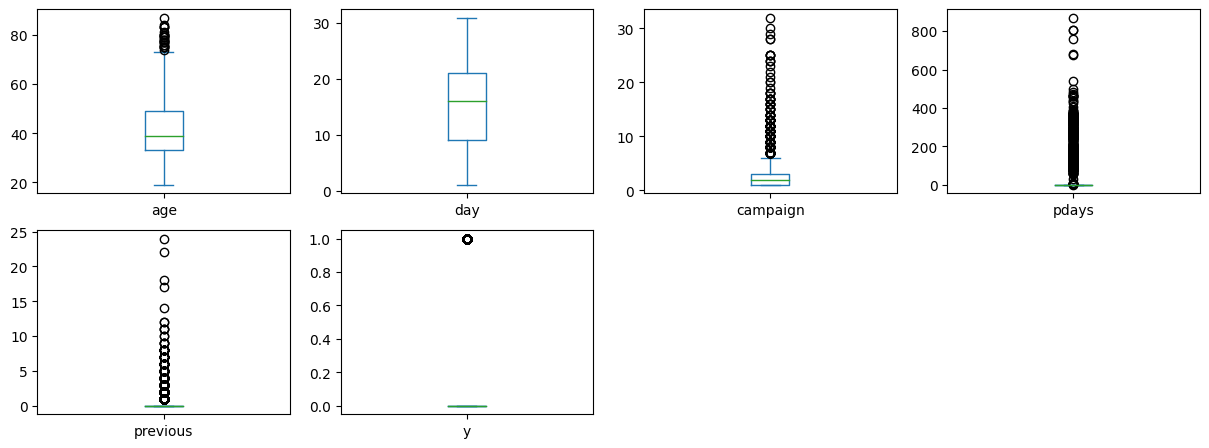

In [ ]:
# Boxplot
train_copy[quant_cols].plot(kind='box', subplots=True, layout=(4,4), sharex=False, figsize=(15, 11))
plt.show()

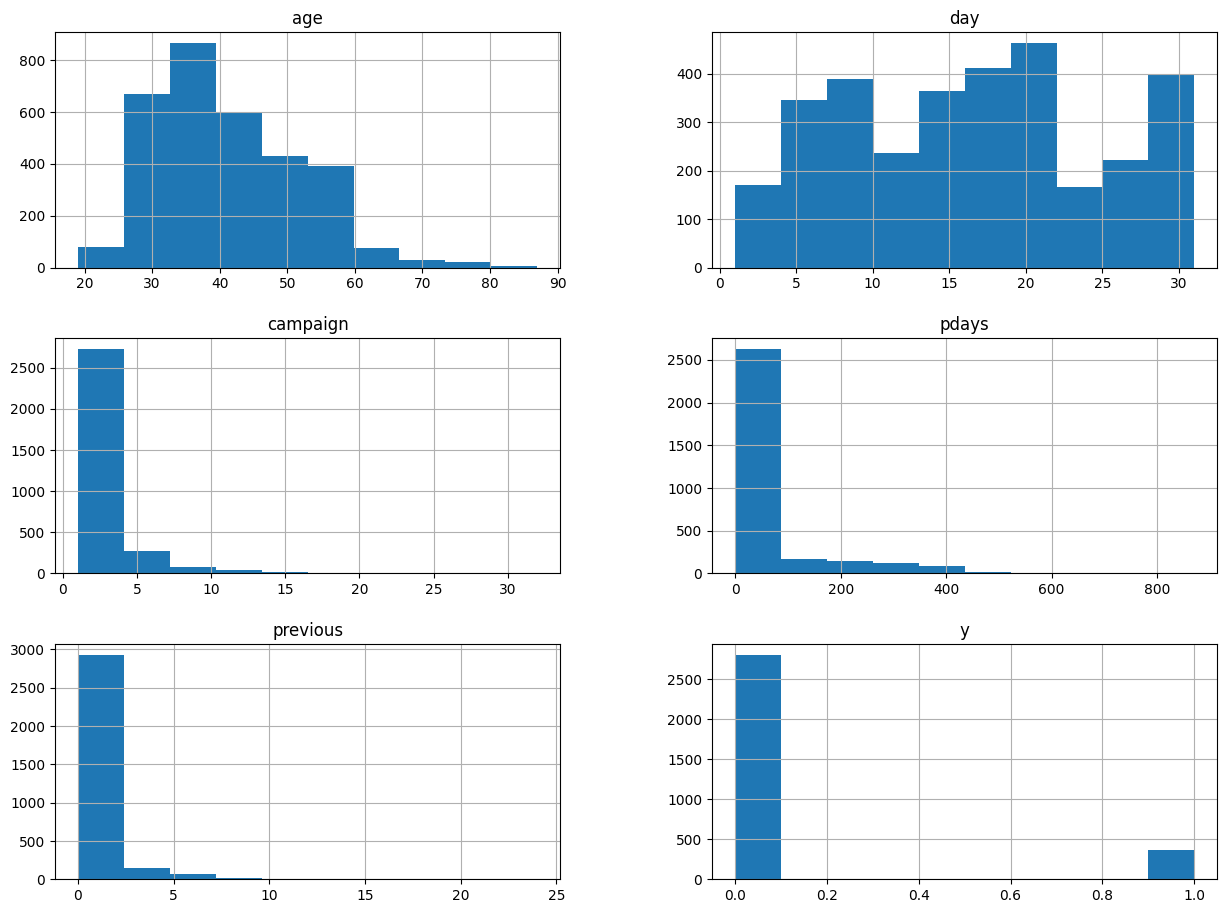

In [ ]:
# Histogram
train_copy[quant_cols].hist(figsize=(15, 11));
plt.show()

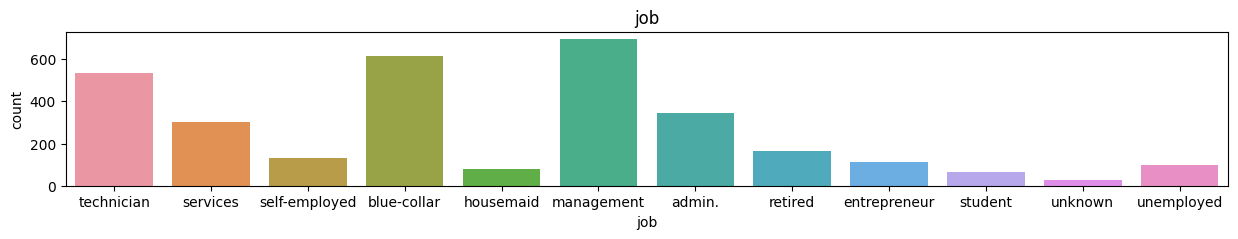

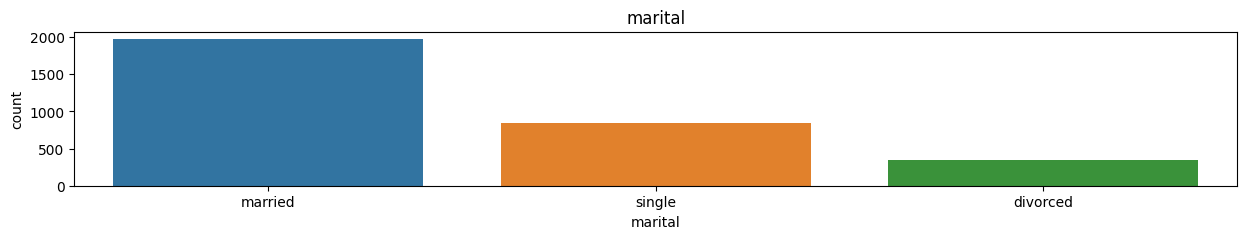

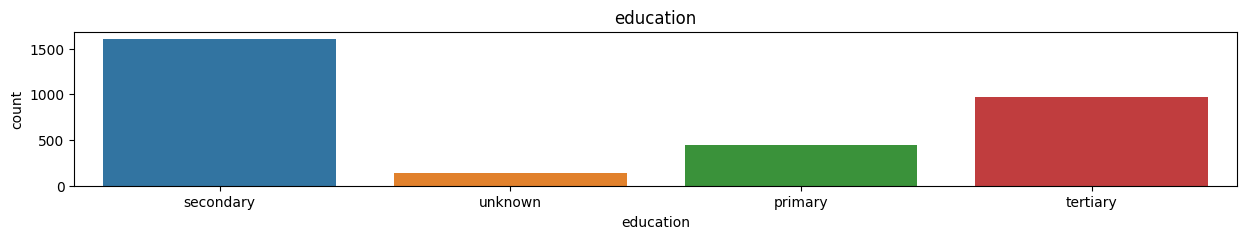

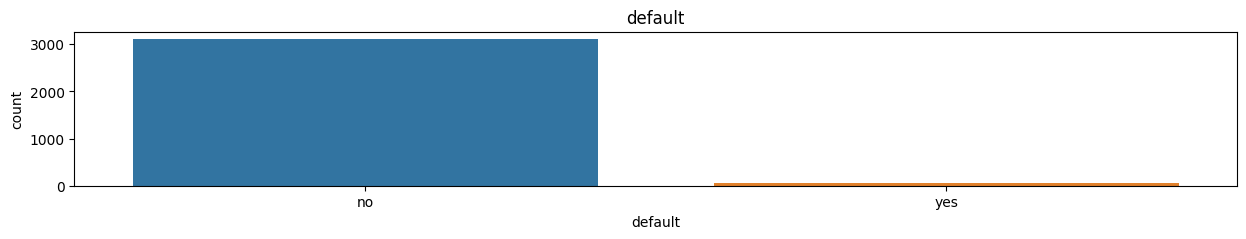

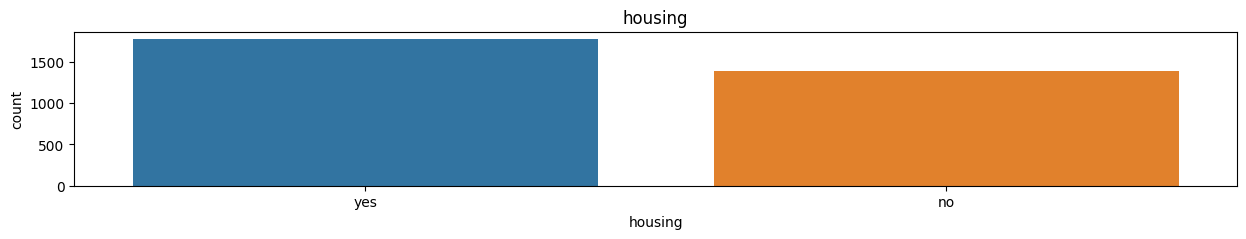

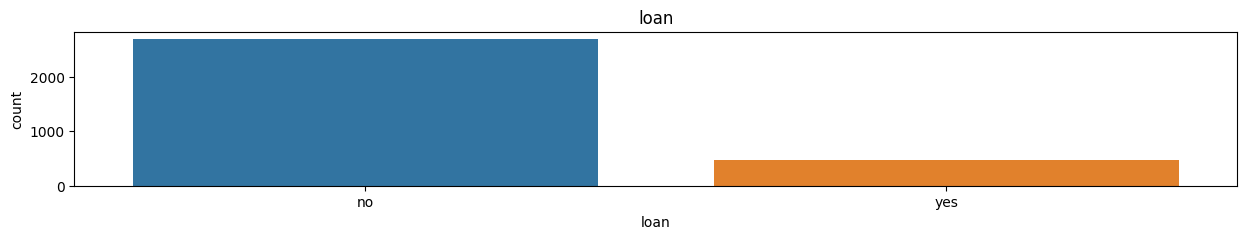

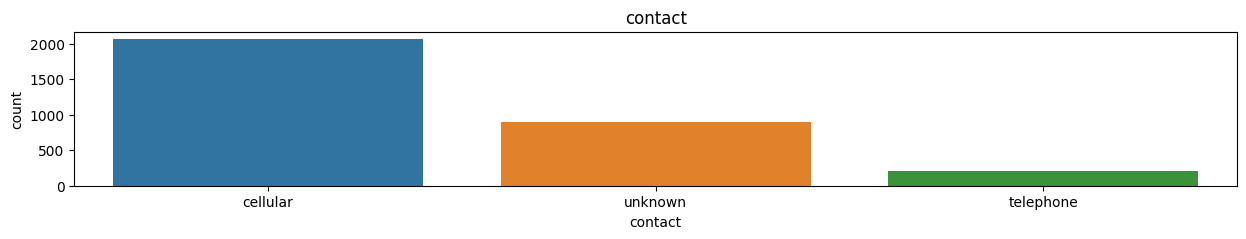

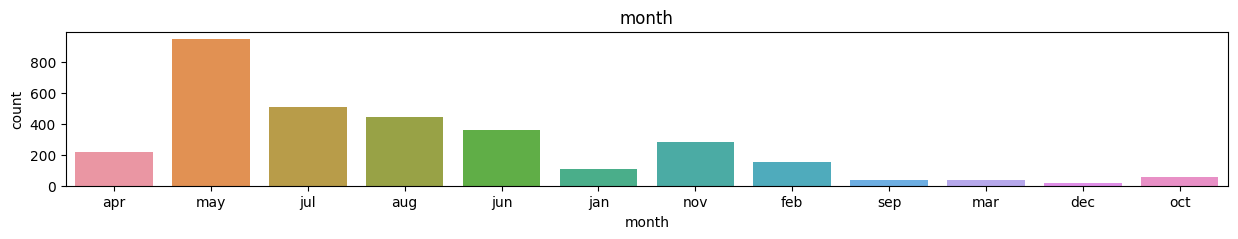

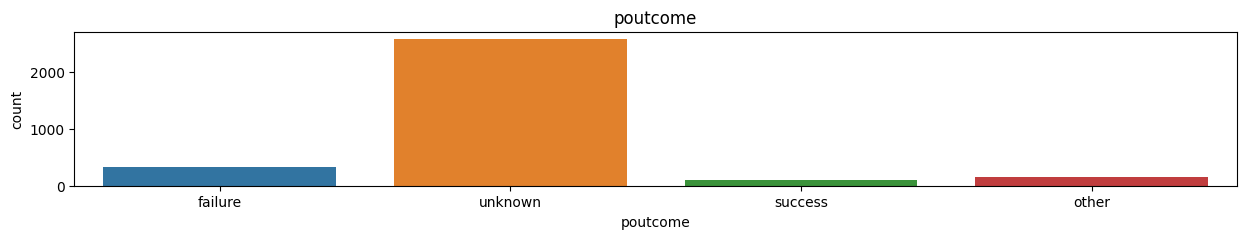

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(15,2))
    sns.countplot(train_copy, x = col)
    plt.title(col)
    plt.show()
    plt.close()

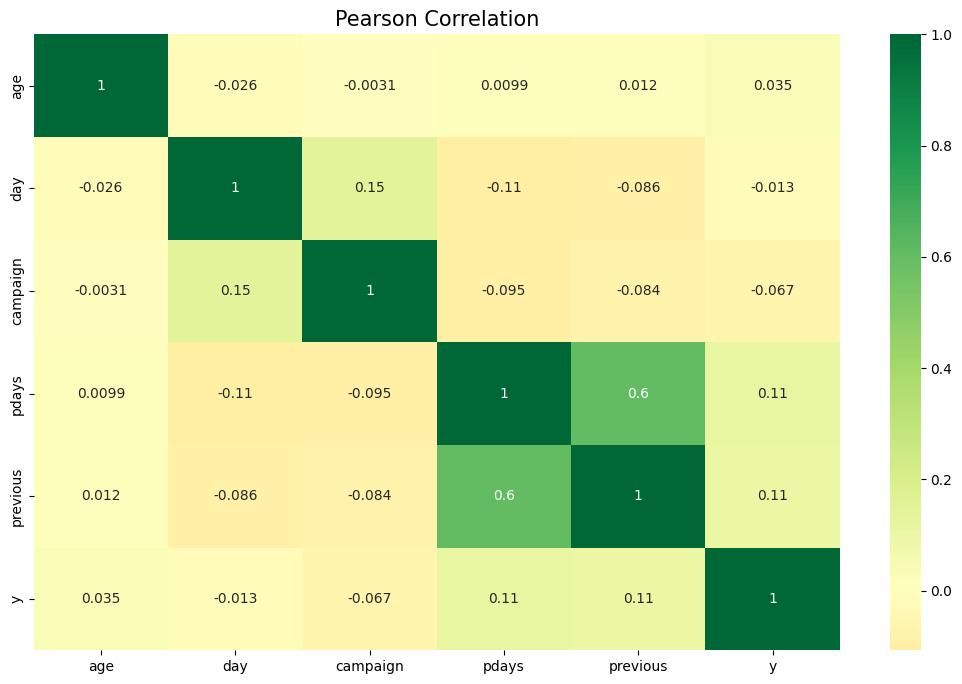

In [ ]:
# Correlation matrix
corr = train_copy[quant_cols].corr(method='pearson');
plt.figure(figsize = (13, 8));
sns.heatmap(corr, cmap='RdYlGn', annot=True, center=0);
plt.title('Pearson Correlation', fontsize=15);
plt.show()

# Pretraitement des données

In [ ]:
# Conversion de la variable "day" en valeur catégorielle
def convert_day(data):
    df = data.copy()
    df["day"]=df["day"].astype(object)
    return df.values



In [ ]:
# Variables numerique
numeric_features = quant_cols[-4:-1]+ ["age"]
numeric_features

['campaign', 'pdays', 'previous', 'age']

In [ ]:
# Variable categorielle
categorical_features = cat_cols[:]+["day"]
categorical_features 

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'day']

In [ ]:
# Pipeline de pretraitement des variables numeriques
numeric_transformer = Pipeline(
    steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('Scaler', StandardScaler())
    ]
)

# Pipeline de pretratement  des variables catégorielles
categorical_transformer = Pipeline(
    steps =[
        ('convert', FunctionTransformer(convert_day)),
        ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[('numeric',numeric_transformer, numeric_features),
                  ('categorical', categorical_transformer, categorical_features)]
)

print( preprocessor)


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('Scaler', StandardScaler())]),
                                 ['campaign', 'pdays', 'previous', 'age']),
                                ('categorical',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_day at 0x0000028294A4D900>)),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome', 'day'])])


In [ ]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('Scaler', StandardScaler())]),
                                 ['campaign', 'pdays', 'previous', 'age']),
                                ('categorical',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_day at 0x0000028294A4D900>)),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'poutcome', 'day'])])

# MODELISATION

In [ ]:
# Pipeline de modélisation avec le RandomForest
rf_pipe_model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(random_state=seed))
    ]
)

rf_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['campaign', 'pdays',
                                                   'previous', 'age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_day at 0x0000028294A4D900>)),
                                                                  ('OneHotEncoder',
                                                  

In [ ]:
# Pipeline de modélisation avec la regression logistique
logreg_pipe_model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('logreg', LogisticRegression(random_state=seed, max_iter=2000))
    ]
)

logreg_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['campaign', 'pdays',
                                                   'previous', 'age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_day at 0x0000028294A4D900>)),
                                                                  ('OneHotEncoder',
                                                  

In [ ]:
X_train, X_val, Y_train, Y_val = train.drop('y', axis = 1), validate.drop('y', axis = 1), train['y'], validate['y']

print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(3164, 14) (679, 14) (3164,) (679,)


In [ ]:

X_val.head

<bound method NDFrame.head of       age            job  marital  education default housing loan    contact  \
4472   29    blue-collar  married    primary      no     yes   no    unknown   
2042   43    blue-collar  married  secondary      no     yes   no    unknown   
3337   58    blue-collar  married    primary      no     yes   no    unknown   
2190   36     technician  married   tertiary      no      no   no   cellular   
3255   55    blue-collar  married    primary      no      no  yes  telephone   
...   ...            ...      ...        ...     ...     ...  ...        ...   
472    38   entrepreneur  married  secondary     yes     yes   no   cellular   
1197   64     management  married   tertiary      no      no   no  telephone   
2849   40  self-employed  married  secondary      no     yes  yes   cellular   
1462   33        unknown  married  secondary      no      no   no   cellular   
3356   51     technician  married  secondary      no     yes   no   cellular   

      day

In [ ]:
# Entrainnement du modèle de RandomForest
rf_pipe_model.fit(X_train, Y_train)

# Prediction sur les données d'entrainement
y_train_preds_rf = rf_pipe_model.predict(X_train)

#Prediction sur les données de validation
y_val_preds_rf = rf_pipe_model.predict(X_val)

# Evaluation du modèle de Foret aleatoire

print(classification_report(Y_train, y_train_preds_rf))
print(classification_report(Y_val, y_val_preds_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2799
           1       1.00      0.99      1.00       365

    accuracy                           1.00      3164
   macro avg       1.00      1.00      1.00      3164
weighted avg       1.00      1.00      1.00      3164

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       601
           1       0.70      0.09      0.16        78

    accuracy                           0.89       679
   macro avg       0.80      0.54      0.55       679
weighted avg       0.87      0.89      0.85       679



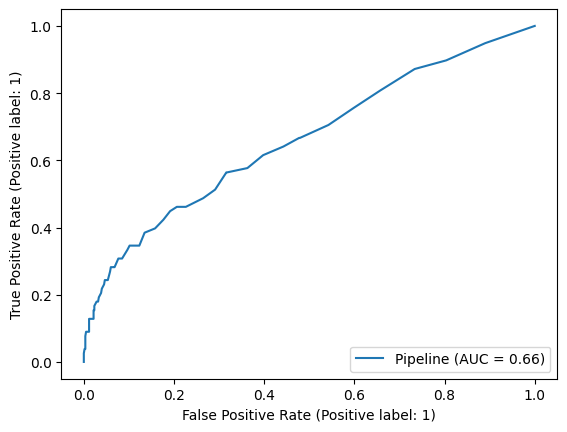

In [ ]:
rf_roc= RocCurveDisplay.from_estimator(rf_pipe_model, X_val, Y_val)
print(rf_roc)

In [ ]:
# Entrainnement du modèle de Regression logistique
logreg_pipe_model.fit(X_train, Y_train)

# Prediction sur les données d'entrainement
y_train_preds_logreg = logreg_pipe_model.predict(X_train)

#Prediction sur les données de validation
y_val_preds_logreg = logreg_pipe_model.predict(X_val)

# Evaluation du modèle de Foret aleatoire

print(classification_report(Y_train, y_train_preds_logreg))
print(classification_report(Y_val, y_val_preds_logreg))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2799
           1       0.67      0.16      0.26       365

    accuracy                           0.89      3164
   macro avg       0.78      0.58      0.60      3164
weighted avg       0.87      0.89      0.86      3164

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       601
           1       0.67      0.08      0.14        78

    accuracy                           0.89       679
   macro avg       0.78      0.54      0.54       679
weighted avg       0.87      0.89      0.85       679



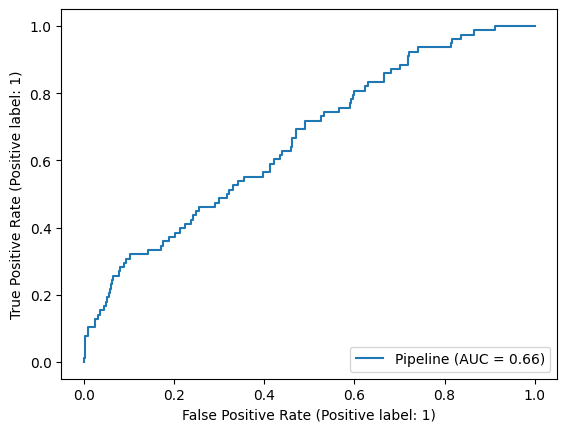

In [ ]:
logreg_roc= RocCurveDisplay.from_estimator(logreg_pipe_model, X_val, Y_val)
print(logreg_roc)

In [ ]:
print(logreg_pipe_model.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'logreg', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numeric', 'preprocessor__categorical', 'preprocessor__numeric__memory', 'preprocessor__numeric__steps', 'preprocessor__numeric__verbose', 'preprocessor__numeric__imputer', 'preprocessor__numeric__Scaler', 'preprocessor__numeric__imputer__add_indicator', 'preprocessor__numeric__imputer__copy', 'preprocessor__numeric__imputer__fill_value', 'preprocessor__numeric__imputer__missing_values', 'preprocessor__numeric__imputer__strategy', 'preprocessor__numeric__imputer__verbose', 'preprocessor__numeric__Scaler__copy', 'preprocessor__numeric__Scaler__with_mean', 'preprocessor__numeric__Scaler__with_std', 'preprocessor__categorical__memory', 'preprocessor__categorical__steps', 'preprocessor__categor

## Optimisation de la performance du meilleur modèle

In [ ]:


pipeline_model = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('logreg', LogisticRegression(random_state=seed, max_iter=2000))
    ]
)

param_grid = {
    'logreg__solver': ['lbfgs', 'saga', 'sag','newton-cg', 'liblinear'],
    'logreg__penalty': ['l2'],
    'logreg__C': [0.5,1.0, 5.0, 10]
   

}

search_model = GridSearchCV (
    estimator=pipeline_model,
    param_grid=param_grid,
    scoring = 'roc_auc',
    cv = 5,
    n_jobs = -1
)

search_model.fit(X_train, Y_train)
print(search_model.best_params_)
print(search_model.best_score_)

{'logreg__C': 0.5, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
0.7322975924998862


In [ ]:
joblib.dump(search_model.best_estimator_, 'best_model.pkl')

['best_model.pkl']

# Analyse de la performance du meilleur modèle sue les données de test

In [ ]:
loaded_model = joblib.load('best_model.pkl')

loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['campaign', 'pdays',
                                                   'previous', 'age']),
                                                 ('categorical',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_day at 0x0000028294A4D900>)),
                                                                  ('OneHotEncoder',
                                                  

In [ ]:
X_test, y_test = test.drop('y', axis=1), test['y']

y_preds_test = loaded_model.predict(X_test)

print(classification_report(y_test, y_preds_test))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95       600
           1       0.87      0.17      0.28        78

    accuracy                           0.90       678
   macro avg       0.88      0.58      0.61       678
weighted avg       0.90      0.90      0.87       678



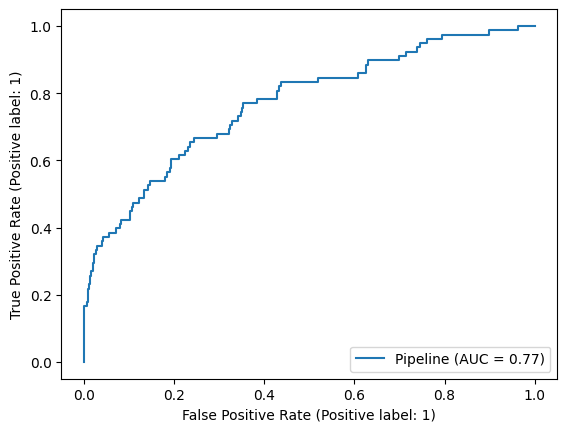

In [ ]:
roc_best = RocCurveDisplay.from_estimator(loaded_model, X_test, y_test)
roc_best